# Softmax回归的从零开始实现

这一节我们来动手实现Softmax回归。首先导入本节实现所需的包或模块。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

## 获取和读取数据

我们将使用Fashion-MNIST数据集，并设置批量大小为256。

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

跟线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本输入是高和宽均为28像素的图像。模型的输入向量的长度是$28 \times 28 = 784$：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10。所以Softmax回归的权重和偏差参数分别为$784 \times 10$和$1 \times 10$的矩阵。

In [3]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

同之前一样，我们要对模型参数附上梯度。

In [4]:
W.attach_grad()
b.attach_grad()

## 实现Softmax运算

在介绍如何定义Softmax回归之前，我们先描述一下对如何对多维NDArray按维度操作。在下面例子中，给定一个NDArray矩阵`X`。我们可以只对其中同一列（`axis=0`）或同一行（`axis=1`）的元素求和，并在结果中保留行和列这两个维度（`keepdims=True`）。

In [5]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

下面我们就可以定义前面小节里介绍的softmax运算了。在下面的函数中，矩阵`X`的行数是样本数，列数是输出个数。为了表达样本预测各个输出的概率，softmax运算会先通过`exp`函数对每个元素做指数运算，再对`exp`矩阵同行元素求和，最后令矩阵每行各元素与该行元素之和相除。这样一来，最终得到的矩阵每行元素和为1且非负。因此，该矩阵每行都是合法的概率分布。Softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。

In [6]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

可以看到，对于随机输入，我们将每个元素变成了非负数，且每一行和为1。

In [7]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.21324193 0.33961776 0.1239742  0.27106097 0.05210521]
  [0.11462264 0.3461234  0.19401033 0.29583326 0.04941036]]
 <NDArray 2x5 @cpu(0)>, 
 [1.0000001 1.       ]
 <NDArray 2 @cpu(0)>)

## 定义模型

有了softmax运算，我们可以定义上节描述的softmax回归模型了。这里通过`reshape`函数将每张原始图像改成长度为`num_inputs`的向量。

In [8]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## 定义损失函数

上一节中，我们介绍了softmax回归使用的交叉熵损失函数。为了得到标签的预测概率，我们可以使用`pick`函数。在下面例子中，变量`y_hat`是2个样本在3个类别的预测概率，变量`y`是这2个样本的标签类别。通过使用`pick`函数，我们得到了2个样本的标签的预测概率。与[“Softmax回归”](softmax-regression.md)一节数学表述中标签类别离散值从1开始逐一递增不同，在代码中，标签类别的离散值是从0开始逐一递增的。

In [9]:
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

以下实现了[“Softmax回归”](softmax-regression.md)一节中介绍的交叉熵损失函数。

In [10]:
def cross_entropy(y_hat, y):
    return - nd.pick(y_hat, y).log()

## 计算分类准确率

给定一个类别的预测概率分布`y_hat`，我们把预测概率最大的类别作为输出类别。如果它与真实类别`y`一致，说明这次预测是正确的。分类准确率即正确预测数量与总预测数量之比。

为了演示准确率的计算，下面定义准确率`accuracy`函数。其中`y_hat.argmax(axis=1)`返回矩阵`y_hat`每行中最大元素的索引，且返回结果与变量`y`形状相同。我们在[“数据操作”](../chapter_prerequisite/ndarray.md)一节介绍过，相等条件判断式`(y_hat.argmax(axis=1) == y)`是一个值为0（相等为假）或1（相等为真）的NDArray。由于标签类型为整数，我们先将变量`y`变换为浮点数再进行相等条件判断。

In [11]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

让我们继续使用在演示`pick`函数时定义的变量`y_hat`和`y`，并将它们分别作为预测概率分布和标签。可以看到，第一个样本预测类别为2（该行最大元素0.6在本行的索引为2），与真实标签0不一致；第二个样本预测类别为2（该行最大元素0.5在本行的索引为2），与真实标签2一致。因此，这两个样本上的分类准确率为0.5。

In [12]:
accuracy(y_hat, y)

0.5

类似地，我们可以评价模型`net`在数据集`data_iter`上的准确率。

In [13]:
# 本函数已保存在d2lzh包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中
# 描述。
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

因为我们随机初始化了模型`net`，所以这个随机模型的准确率应该接近于类别个数10的倒数0.1。

In [14]:
evaluate_accuracy(test_iter, net)

0.0925

## 训练模型

训练softmax回归的实现跟前面介绍的线性回归中的实现非常相似。我们同样使用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数`num_epochs`和学习率`lr`都是可以调的超参数。改变它们的值可能会得到分类更准确的模型。

In [15]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)  # 下一节将用到
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size,
          [W, b], lr)

epoch 1, loss 0.7896, train acc 0.745, test acc 0.803


epoch 2, loss 0.5728, train acc 0.812, test acc 0.818


epoch 3, loss 0.5296, train acc 0.824, test acc 0.833


epoch 4, loss 0.5057, train acc 0.829, test acc 0.832


epoch 5, loss 0.4895, train acc 0.835, test acc 0.840


## 预测

训练完成后，现在我们可以演示如何对图像进行分类。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

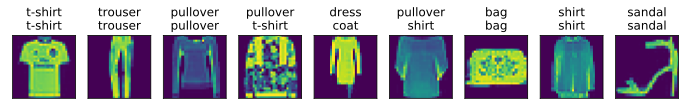

In [16]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

## 小结
 
* 我们可以使用softmax回归做多类别分类。与训练线性回归相比，你会发现训练softmax回归的步骤和它非常相似：获取并读取数据、定义模型和损失函数并使用优化算法训练模型。事实上，绝大多数深度学习模型的训练都有着类似的步骤。

## 练习

* 本节中，我们直接按照softmax运算的数学定义来实现softmax函数。这可能会造成什么问题？（提示：试一试计算$\exp(50)$的大小。）
* 本节中的`cross_entropy`函数是按照交叉熵损失函数的数学定义实现的。这样的实现方式可能有什么问题？（提示：思考一下对数函数的定义域。）
* 你能想到哪些办法来解决上面的两个问题？

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/741)

![](../img/qr_softmax-regression-scratch.svg)